In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from lifelines import CoxPHFitter, KaplanMeierFitter
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection

# Data reading, cleaning and merging

In [2]:
data = pd.read_csv("../summary_data/sbt_features_oncopanel.csv")
data = data.set_index('Sample ID')

data = data.loc[data['Primary Cancer Diagnosis'] == 'Lung Adenocarcinoma', ]
data = data.loc[data['Biopsy Site Type'] != 'PRIMARY', ]

data.shape

(1200, 83)

## Filtering data

In [3]:
# Remove invalid values
data = data.loc[data['Tumor Purity'] > 0]
data = data.loc[data['offcov'] <= 0.5]

data = data.rename(columns={"Age at Treatment Start":"Age"})
data = data.loc[data['Age'] > 0]

data['Sex'] = data['Sex'] == "Female"
data['Sex'] = data['Sex'].astype(int)

data['Panel Version'] = data['Panel Version'].astype(float)

data['Panel_Version_1'] = data['Panel Version'] == 1.0
data['Panel_Version_1'] = data['Panel_Version_1'].astype(float)

data['Panel_Version_2'] = data['Panel Version'] == 2.0
data['Panel_Version_2'] = data['Panel_Version_2'].astype(float)


data['Line_of_Treatment_0'] = data['Line of Treatment'] == 0
data['Line_of_Treatment_0'] =  data['Line_of_Treatment_0'].astype(float)


data['time'] = data['tstop'] - data['tstart']

N = data.shape[0]

data['rank_age'] = data["Age"].rank(method='first').reindex_like(data["Age"])/N

data["Age_top"] = 0    
data.loc[data['rank_age'] > 0.66, 'Age_top'] = 1

data["Age_bottom"] = 0    
data.loc[data['rank_age'] <= 0.33, 'Age_bottom'] = 1

data["Age_middle"] = 0    
data.loc[(data['rank_age'] > 0.33) & (data['rank_age'] <= 0.66) , 'Age_middle'] = 1


In [4]:
feature_dict_names = {'mtDNA_dosage_norm':'mtDNA copy number', '5S_dosage_norm':'5S rDNA copy number', 
                      '18S_dosage_norm':'18S rDNA copy number', '28S_dosage_norm':'28S rDNA copy number', 
                      '45S_dosage_norm':'45S rDNA copy number', 'n_fungi_norm':'fungal load', 
                      'n_microbial_norm':'microbial load', 'n_protozoa_norm':'protozoa load', 
                      'n_viral_norm':'viral load', 'loadIG_ligth_chain_norm':'IG κ and λ infiltration', 
                      'loadIG_norm':'BCR infiltration', 'loadIGH_norm':'IGH infiltration', 
                      'loadIGK_norm':'IG κ infiltration', 'loadIGL_norm':'IG λ infiltration', 
                      'loadTCR_norm':'T cell infiltration', 'loadTCRA_norm':'T cell α infiltration', 
                      'loadTCRB_norm':'T cell β infiltration', 'loadTCRD_norm':'T cell δ infiltration',
                      'loadTCRG_norm':'T cell γ infiltration', 'nIG_ligth_chain_norm':'IG κ and λ richness', 
                      'nIG_norm':'BCR richness', 'nIGH_norm':'IGH richness', 'nIGK_norm':'IG κ richness', 
                      'nIGL_norm':'IG λ richness', 'nTCR_norm':'TCR richness', 'nTCRA_norm':'TCR α richness', 
                      'nTCRB_norm':'TCR β richness', 'nTCRD_norm':'TCR δ richness', 'nTCRG_norm':'TCR γ richness',
                      'alphaIGH':'IGH Shannon', 'alphaIGK':'IG κ Shannon', 'alphaIGL':'IG λ Shannon', 
                      'alphaTCRA':'TCR α Shannon', 'alphaTCRB':'TCR β Shannon', 'alphaTCRD':'TCR δ Shannon', 
                      'alphaTCRG':'TCR γ Shannon'}

# SBT features, covariates and outcomes

In [5]:
features = ['mtDNA_dosage_norm', 
            '5S_dosage_norm', '18S_dosage_norm','28S_dosage_norm', '45S_dosage_norm', 
            'n_fungi_norm', 'n_microbial_norm', 'n_protozoa_norm', 'n_viral_norm', 
            'nIG_norm', 'nIG_ligth_chain_norm', 'nIGH_norm',  'nIGK_norm',  'nIGL_norm', 
            'nTCR_norm', 'nTCRA_norm',  'nTCRB_norm',  'nTCRD_norm',  'nTCRG_norm',  
            'loadIG_norm', 'loadIG_ligth_chain_norm', 
            'loadIGH_norm',  'loadIGK_norm',  'loadIGL_norm', 
            'loadTCR_norm', 'loadTCRA_norm',  'loadTCRB_norm',  'loadTCRD_norm',  'loadTCRG_norm',
            'alphaIGH',  'alphaIGK',  'alphaIGL',  
            'alphaTCRA',  'alphaTCRB',  'alphaTCRD',  'alphaTCRG']


covariates = ['offcov', 'Tumor Purity', 'Age', "Age_top", "Age_middle", "Age_bottom", 'Sex', 
              'Panel_Version_1', 'Panel_Version_2', 'Line_of_Treatment_0']

# Distribution of covariates

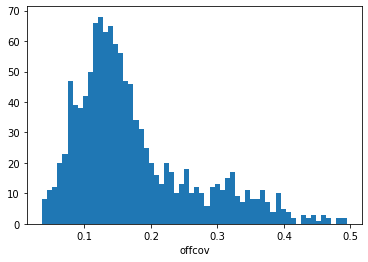

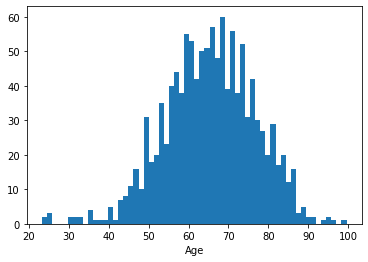

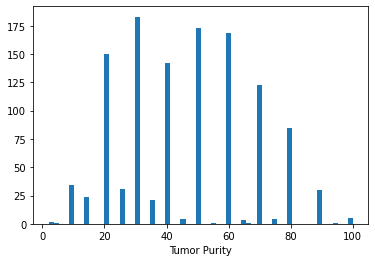

In [6]:
for column in['offcov', 'Age', 'Tumor Purity']:
   
    plt.hist(data[column], bins=60)
    plt.xlabel(column)
    plt.show()

# Zero inflated SBT features ( >10%)

nIG_norm Zero portion:  78.43302443133952 % nonzero inviduals:  256


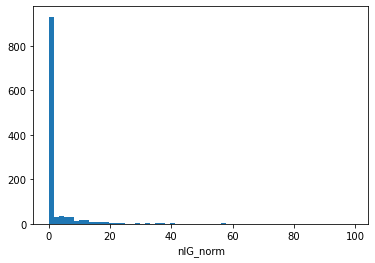

nIG_ligth_chain_norm Zero portion:  81.97135636057288 % nonzero inviduals:  214


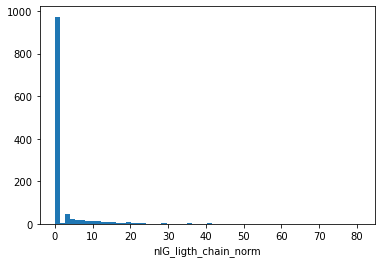

nIGH_norm Zero portion:  89.63774220724515 % nonzero inviduals:  123


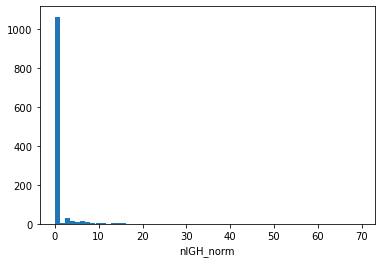

nIGK_norm Zero portion:  99.83150800336983 % nonzero inviduals:  2


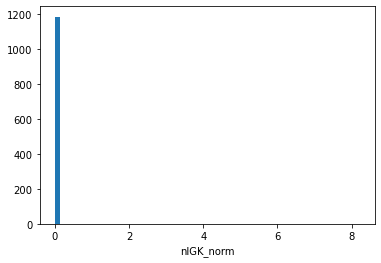

nIGL_norm Zero portion:  82.05560235888795 % nonzero inviduals:  213


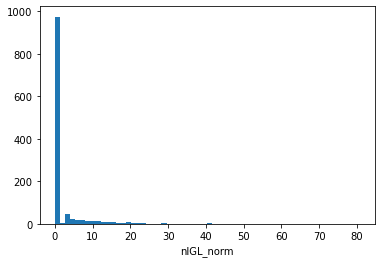

nTCR_norm Zero portion:  39.34288121314238 % nonzero inviduals:  720


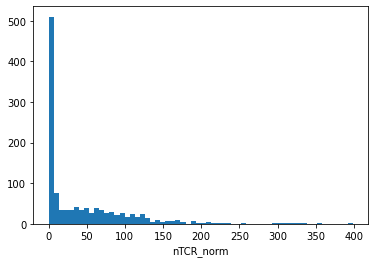

nTCRA_norm Zero portion:  39.34288121314238 % nonzero inviduals:  720


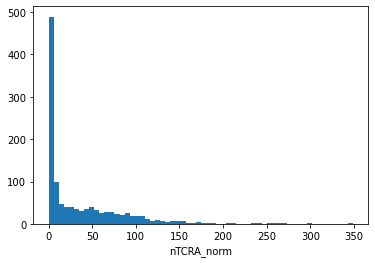

nTCRB_norm Zero portion:  63.521482729570344 % nonzero inviduals:  433


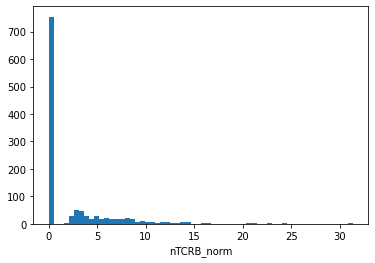

nTCRD_norm Zero portion:  99.5787700084246 % nonzero inviduals:  5


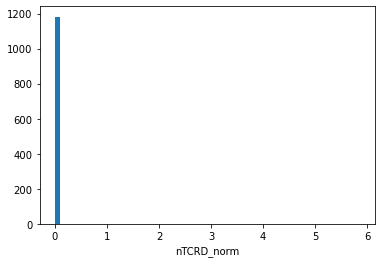

nTCRG_norm Zero portion:  67.81802864363942 % nonzero inviduals:  382


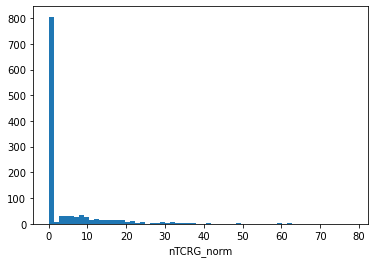

loadIG_norm Zero portion:  78.43302443133952 % nonzero inviduals:  256


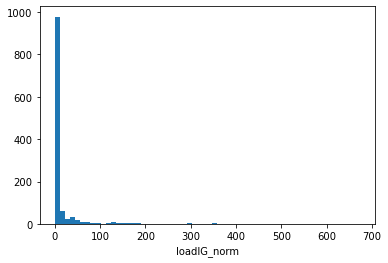

loadIG_ligth_chain_norm Zero portion:  81.97135636057288 % nonzero inviduals:  214


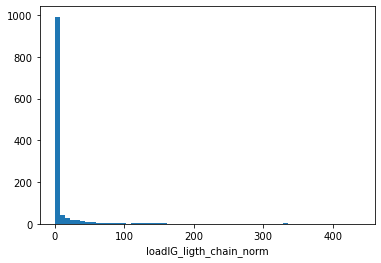

loadIGH_norm Zero portion:  89.63774220724515 % nonzero inviduals:  123


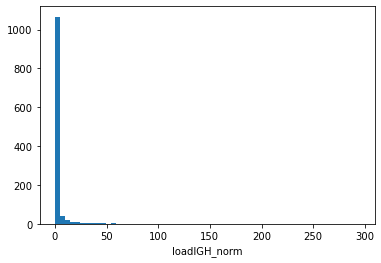

loadIGK_norm Zero portion:  99.83150800336983 % nonzero inviduals:  2


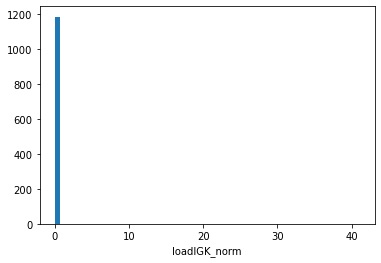

loadIGL_norm Zero portion:  82.05560235888795 % nonzero inviduals:  213


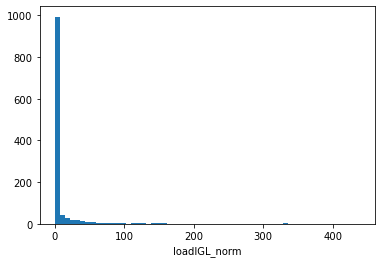

loadTCR_norm Zero portion:  39.34288121314238 % nonzero inviduals:  720


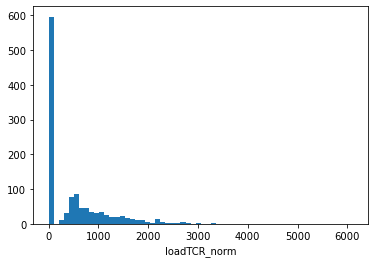

loadTCRA_norm Zero portion:  39.34288121314238 % nonzero inviduals:  720


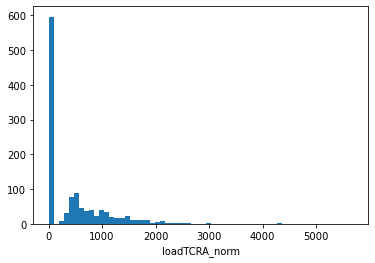

loadTCRB_norm Zero portion:  63.521482729570344 % nonzero inviduals:  433


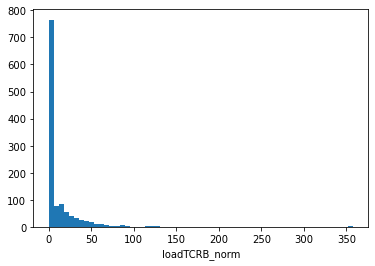

loadTCRD_norm Zero portion:  99.5787700084246 % nonzero inviduals:  5


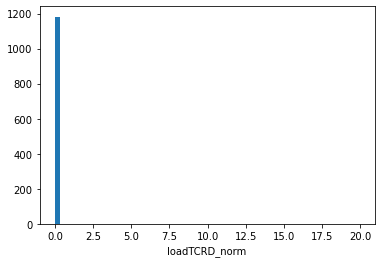

loadTCRG_norm Zero portion:  67.81802864363942 % nonzero inviduals:  382


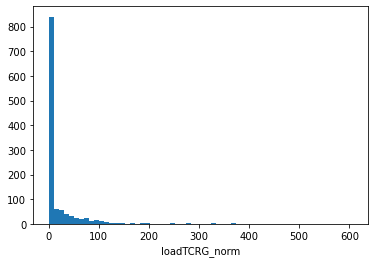

alphaIGH Zero portion:  95.53496208930076 % nonzero inviduals:  53


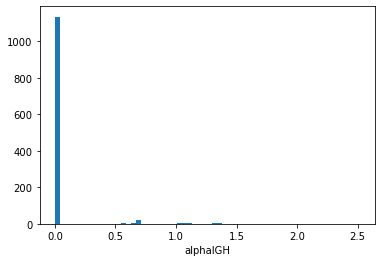

alphaIGK Zero portion:  100.0 % nonzero inviduals:  0


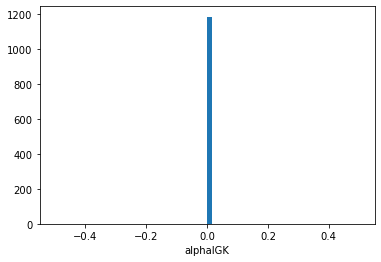

alphaIGL Zero portion:  91.49115417017691 % nonzero inviduals:  101


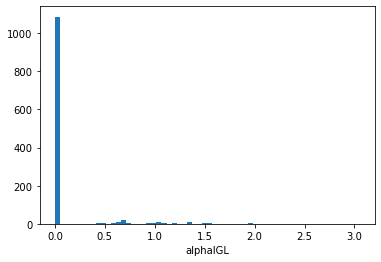

alphaTCRA Zero portion:  48.44144903117102 % nonzero inviduals:  612


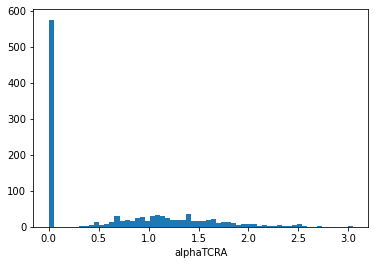

alphaTCRB Zero portion:  92.16512215669755 % nonzero inviduals:  93


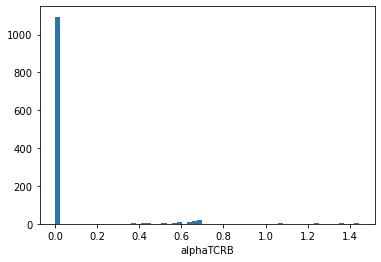

alphaTCRD Zero portion:  99.91575400168492 % nonzero inviduals:  1


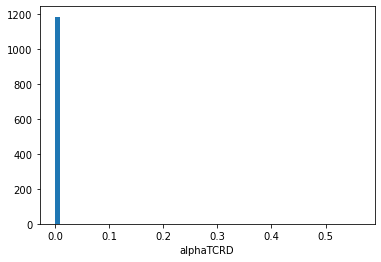

alphaTCRG Zero portion:  78.18028643639427 % nonzero inviduals:  259


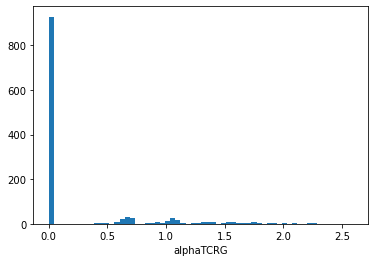

In [7]:
features_zero_inflated_ = ['nIG_norm', 'nIG_ligth_chain_norm', 'nIGH_norm',  'nIGK_norm',  'nIGL_norm', 
                            'nTCR_norm', 'nTCRA_norm',  'nTCRB_norm',  'nTCRD_norm',  'nTCRG_norm',  
                           'loadIG_norm', 'loadIG_ligth_chain_norm', 
                           'loadIGH_norm',  'loadIGK_norm',  'loadIGL_norm', 
                           'loadTCR_norm', 'loadTCRA_norm',  'loadTCRB_norm',  'loadTCRD_norm',  'loadTCRG_norm',
                           'alphaIGH',  'alphaIGK',  'alphaIGL',  
                           'alphaTCRA',  'alphaTCRB',  'alphaTCRD',  'alphaTCRG']

features_zero_inflated = []

# number of rows
N = data.shape[0]

for feature in features_zero_inflated_:
   
    # number of zeros
    n_zeros = len(data.loc[data[feature] == 0, feature])
    
    # features and portion of zeros
    print(feature, "Zero portion: ",n_zeros/N*100, "%","nonzero inviduals: " ,N - n_zeros)
    
    if N - n_zeros > 30:
        features_zero_inflated.append(feature)
    
    plt.hist(data[feature], bins=60)
    plt.xlabel(feature)
    plt.show()
    

data_zero_inflated = data[features_zero_inflated]



## Variable transformation

### _Q: variable created by inverse normal transformation on non-zero values  
### Formula: qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x)))


### _D: dichotomous variable indicating non-zero values (value 1) and zero values (value 0)


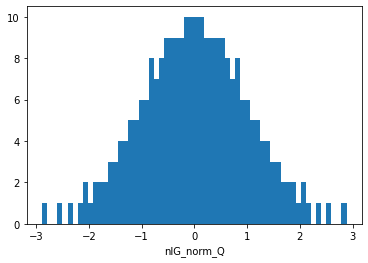

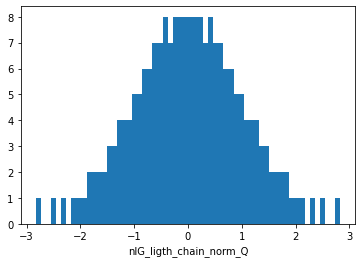

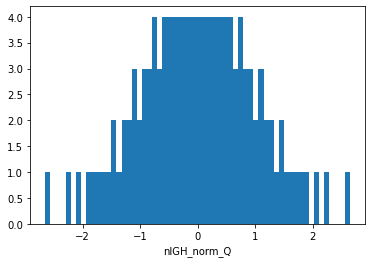

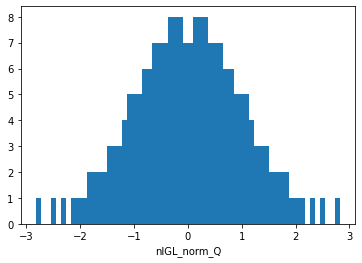

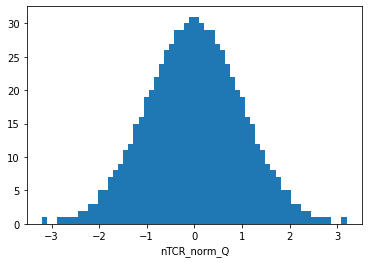

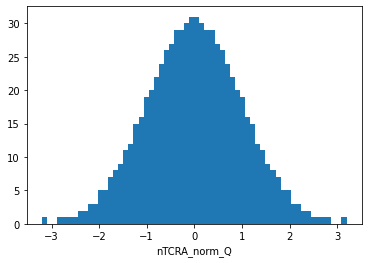

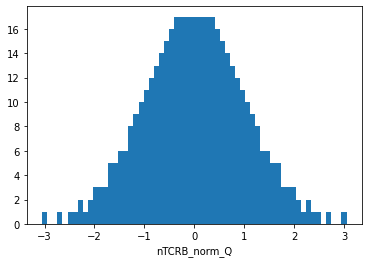

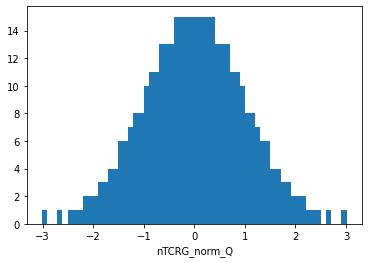

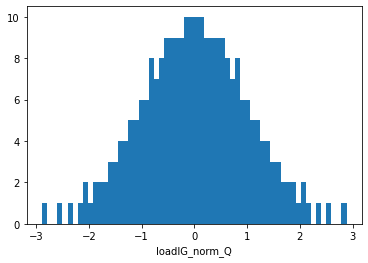

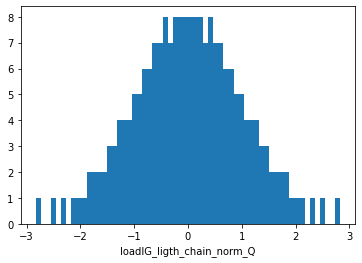

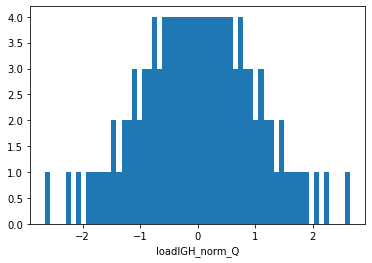

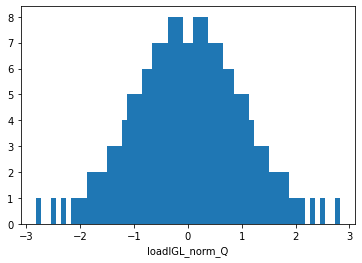

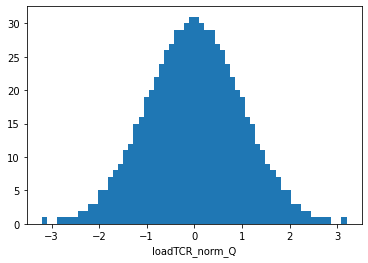

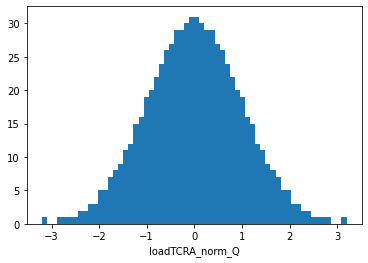

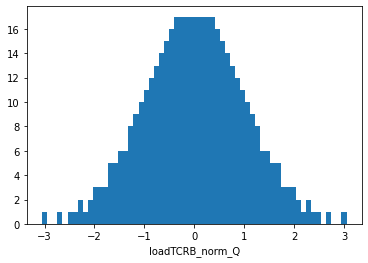

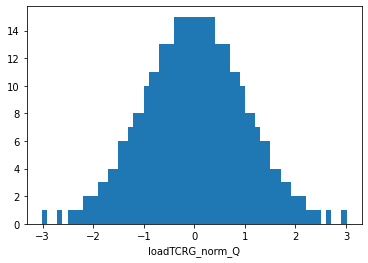

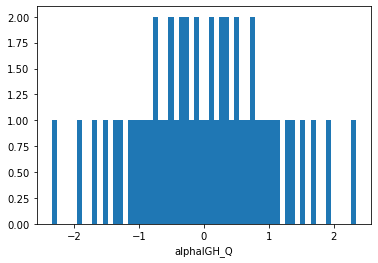

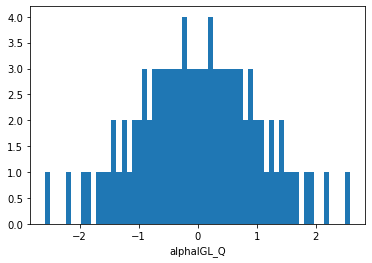

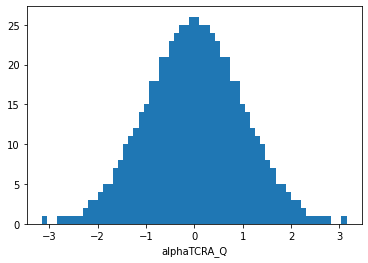

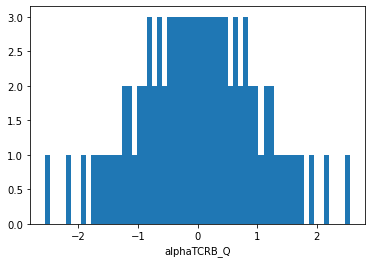

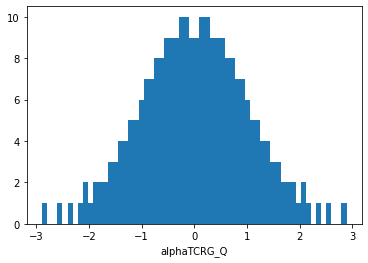

In [8]:
data_zero_inflated_Q = data_zero_inflated.copy()
data_zero_inflated_D = data_zero_inflated.copy()

for feature in features_zero_inflated[0:]:
    
    # Dichotomous variable (_D) with 0 for zero values and 1 otherwise
    data_zero_inflated_D.loc[data_zero_inflated_D[feature] != 0. , feature] = 1.
    
    
    # Inverse normal transformation of non-zero values
    data_feature = data_zero_inflated.loc[data_zero_inflated[feature] != 0., feature]
    data_feature = data_feature.rank(method='first').reindex_like(data_feature)

    for row in data_feature.index: 

        x = norm.ppf((data_feature[row]-0.5)/len(data_feature))
        data_zero_inflated_Q[feature][row] = x
        
        
    # renaming columns   
    data_zero_inflated_Q = data_zero_inflated_Q.rename(columns={feature: feature+"_Q"}, errors="raise")
    data_zero_inflated_D = data_zero_inflated_D.rename(columns={feature: feature+"_D"}, errors="raise")
    
    #Checking new distribution - non-zero values
    x = data_zero_inflated_Q.loc[data_zero_inflated_Q[feature+"_Q"] != 0, feature+"_Q"]
    plt.hist(x, bins=60)
    plt.xlabel(feature+"_Q")
    plt.show()

# Cox regression

In [9]:
data_ = data.copy()
data_ = data_.join(data_zero_inflated_D, on='Sample ID')
data_ = data_.join(data_zero_inflated_Q, on='Sample ID')

Ncovs = 8

#Dataframe to store results
col_names = ['sbt_feature', 'pvalue', 'effect', 'std']

result = pd.DataFrame(columns = col_names)


for feature in features_zero_inflated:
    
    data_rank = data_.copy()
    data_rank = data_rank[['time', 'event', feature+"_D",  feature+"_Q", feature,
                           'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                           'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]
    data_rank = data_rank.dropna()

    # -----------------------------------------------------------------------------------------------------
    # Regression with SBT features  
    
    df = data_rank[['time', 'event', feature+"_D",  feature+"_Q",
                    'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                    'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]
    
    cph = CoxPHFitter()
    
    cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0'])
    
    params = cph.summary
    
    # storing the largest effect
    effect = params['coef'][feature+"_Q"]
    error = cph.standard_errors_[feature+"_Q"]
    if abs(effect) < abs(params['coef'][feature+"_D"]):
        effect = params['coef'][feature+"_D"]
        error = cph.standard_errors_[feature+"_D"]
        
    L1 = cph.log_likelihood_
   
    cph.check_assumptions(df, p_value_threshold=0.05/Ncovs, show_plots=False)
    
    
    
    # -----------------------------------------------------------------------------------------------------
    # Regression with only covariates
    df = data_rank[['time', 'event',
                    'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                    'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]
    
    cph = CoxPHFitter()
        
    cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0'])
    
    L2 = cph.log_likelihood_
    pvalue = 1 - stats.chi2.cdf(2*(L1 - L2), 2)
    
    cph.check_assumptions(df, p_value_threshold=0.05/Ncovs, show_plots=False)
    
    
    result = result.append({'sbt_feature': feature_dict_names[feature], 
                            'pvalue': pvalue,
                            'effect': effect, 
                            'std':error}, 
                            ignore_index=True)

    
result_zero_inflated_survival = result

Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportiona

# SBT features without zero inflation

mtDNA_dosage_norm  - Zero portion:  0.0 %


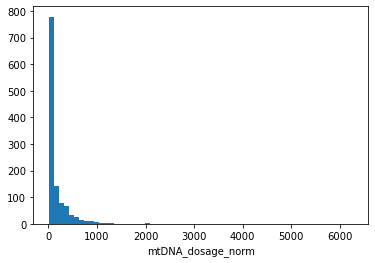

5S_dosage_norm  - Zero portion:  0.0 %


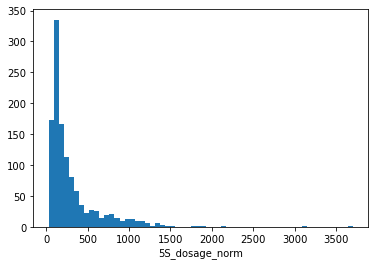

18S_dosage_norm  - Zero portion:  0.016006739679865205 %


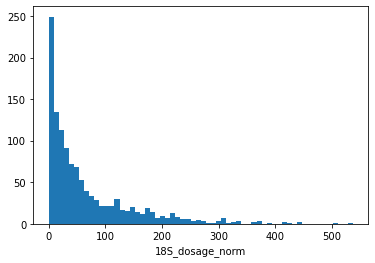

28S_dosage_norm  - Zero portion:  0.0016849199663016006 %


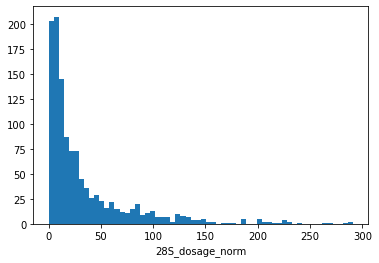

45S_dosage_norm  - Zero portion:  0.0 %


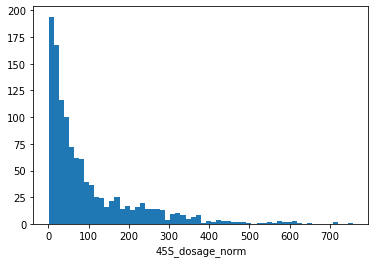

n_fungi_norm  - Zero portion:  0.0 %


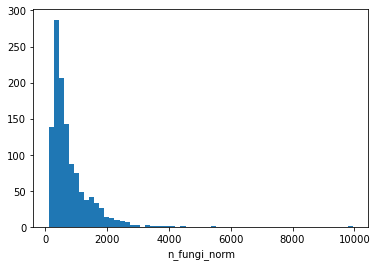

n_microbial_norm  - Zero portion:  0.0 %


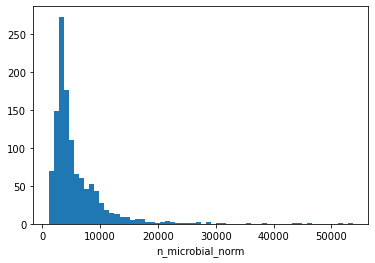

n_protozoa_norm  - Zero portion:  0.0 %


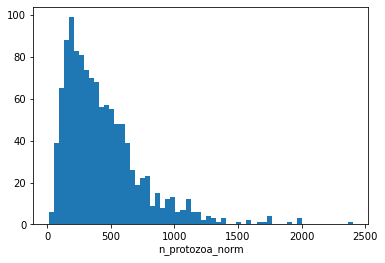

n_viral_norm  - Zero portion:  0.0 %


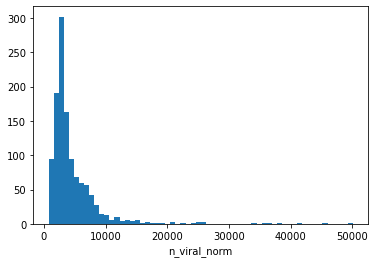

In [10]:
features_non_zero_inflated=['mtDNA_dosage_norm',
                            '5S_dosage_norm','18S_dosage_norm','28S_dosage_norm','45S_dosage_norm',
                            'n_fungi_norm','n_microbial_norm','n_protozoa_norm','n_viral_norm']

# number of rows
N = data.shape[0]

for feature in features_non_zero_inflated:
   
    # number of zeros
    n_zeros = len(data.loc[data[feature] == 0, feature])
    
    # features and portion of zeros
    print(feature, " - Zero portion: ",n_zeros/N, "%")
    plt.hist(data[feature], bins=60)
    plt.xlabel(feature)
    plt.show()

data_non_zero_inflated = data[features_non_zero_inflated]

## Variable transformation

### _Q: variable created by inverse normal transformation (qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x))))
### _D: dichotomous variable indicating top 15% (value 1) and bottom 85% (value 0)

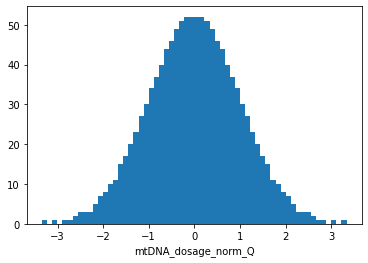

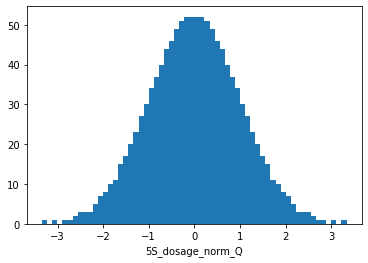

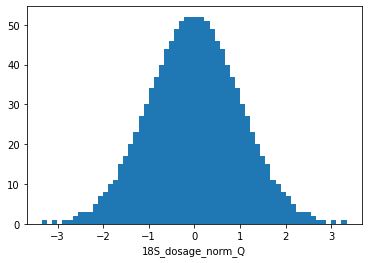

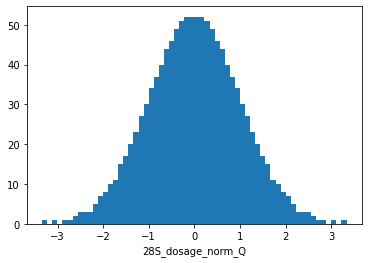

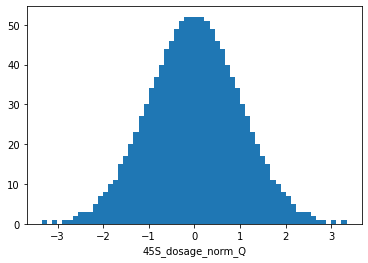

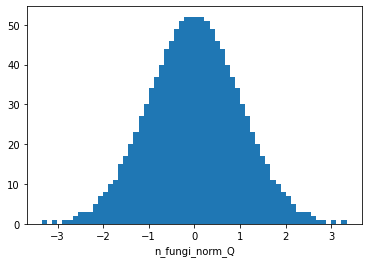

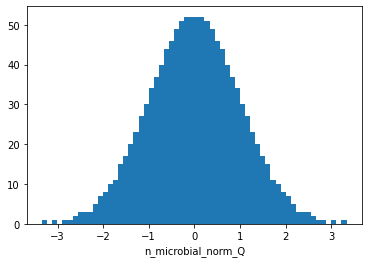

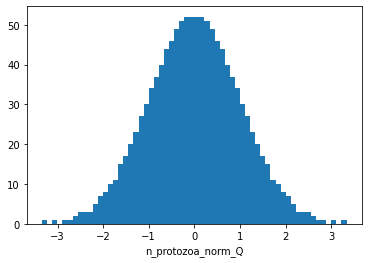

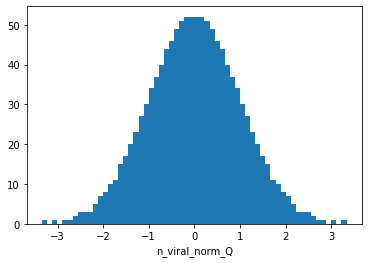

In [11]:
data_non_zero_inflated_Q = data_non_zero_inflated.copy()

N = data_non_zero_inflated.shape[0]

data_non_zero_inflated_D = data_non_zero_inflated.rank()/N  

for feature in features_non_zero_inflated:
    
    # Dichotomous variable with 0 for the bottom 85% of data and 1 for the top 15% 
    data_non_zero_inflated_D.loc[data_non_zero_inflated_D[feature] < 0.85, feature] = 0.
    data_non_zero_inflated_D.loc[data_non_zero_inflated_D[feature] >= 0.85, feature] = 1.
    
    
    # Inverse normal transformation
    data_feature = data_non_zero_inflated[feature]
    data_feature = data_feature.rank(method='first').reindex_like(data_feature)

    for row in data_feature.index: 

        x = norm.ppf((data_feature[row]-0.5)/len(data_feature))
        data_non_zero_inflated_Q[feature][row] = x
        
        
    # renaming columns   
    data_non_zero_inflated_Q = data_non_zero_inflated_Q.rename(columns={feature: feature+"_Q"}, errors="raise")
    data_non_zero_inflated_D = data_non_zero_inflated_D.rename(columns={feature: feature+"_D"}, errors="raise")
    
    #Checking new distribution - non-zero values
    x = data_non_zero_inflated_Q.loc[data_non_zero_inflated_Q[feature+"_Q"] != 0, feature+"_Q"]
    plt.hist(x, bins=60)
    plt.xlabel(feature+"_Q")
    plt.show()

# Cox Regression

In [12]:
data_ = data.copy()
data_ = data_.join(data_non_zero_inflated_D, on='Sample ID')
data_ = data_.join(data_non_zero_inflated_Q, on='Sample ID')
Ncovs = 8

#Dataframe to store results
col_names = ['sbt_feature', 'pvalue', 'effect', 'std']
result  = pd.DataFrame(columns = col_names)


for feature in features_non_zero_inflated:
    
    
    data_rank = data_.copy()
    data_rank = data_rank[['time', 'event', feature+"_Q", feature,
                'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]

    data_rank = data_rank.dropna()    
    
    # -----------------------------------------------------------------------------------------------------
    # Regression with _Q        
    
    df = data_rank[['time', 'event', feature+"_Q",
                   'Age_top', 'Age_bottom', 'Sex', 'Tumor Purity', 'offcov',
                   'Panel_Version_1',  'Panel_Version_2', 'Line_of_Treatment_0']]  
    
    cph = CoxPHFitter()      
    
    cph.fit(df, duration_col='time', event_col='event', strata=['Line_of_Treatment_0'])
        
    error = cph.standard_errors_[feature+"_Q"]
    params_Q = cph.summary 
    
    cph.check_assumptions(df, p_value_threshold=0.05/Ncovs, show_plots=False)
   
    result = result.append({'sbt_feature': feature_dict_names[feature], 
                            'pvalue': params_Q['p'][feature+"_Q"] ,
                            'effect': params_Q['coef'][feature+"_Q"], 
                            'std':error}, 
                            ignore_index=True)


result_non_zero_inflated_survival = result

Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.
Proportional hazard assumption looks okay.


In [13]:
result = pd.concat([result_non_zero_inflated_survival,result_zero_inflated_survival])
    
result['qvalue'] = fdrcorrection(result['pvalue'])[1]
result.to_csv('../summary_data/survival_results_op-luad_nonprimary.csv', index=False)
result.loc[(result['qvalue'] < 0.1) ,]


,sbt_feature,pvalue,effect,std,qvalue
1,5S rDNA copy number,0.001025,0.160305,0.048821,0.015377
5,fungal load,0.000286,0.217210,0.059870,0.008568
12,T cell infiltration,0.011514,0.336450,0.127665,0.069082
13,T cell α infiltration,0.008252,0.343625,0.128089,0.061889
18,TCR α Shannon,0.004505,0.524473,0.163815,0.045046
